In [153]:
!pip install pmdarima

In [252]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels import api as sm
import plotly.subplots as sp
import math
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.model_selection import ParameterGrid

# Exploring the Data

In [253]:
df= pd.read_csv(r"C:\Users\47462\OneDrive\Desktop\Time Series Analysi\daily_revenue.csv", index_col="date", parse_dates=True,
               dayfirst= True)
df.head()


,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [255]:
df.describe()

,revenue,discount_rate,coupon_rate
count,1795,1795,1795
unique,1795,1144,287
top,"6,270,839",15.18%,0.29%
freq,1,6,55


# Data Pre-Processing


In [256]:
# remove comma and transform to 
df['revenue']=df['revenue'].str.replace(',','').astype(float)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


In [257]:
#set frequency 
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq=None)

In [258]:
#setting freq to W implies that week starts on a sunday
df=df.asfreq("D")

In [259]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [260]:
# Change the time searies variale name
df= df.rename(columns={'revenue':'y'})
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


# Exploratory Data Analysis

In [99]:
# finding null values

df['y'].fillna(method='bfill',inplace=True)
df['discount_rate'].fillna(method='bfill',inplace=True)
df['coupon_rate'].fillna(method='bfill',inplace=True)
print(df.isnull().sum())

y                0
discount_rate    0
coupon_rate      0
dtype: int64


In [117]:
df= df.dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

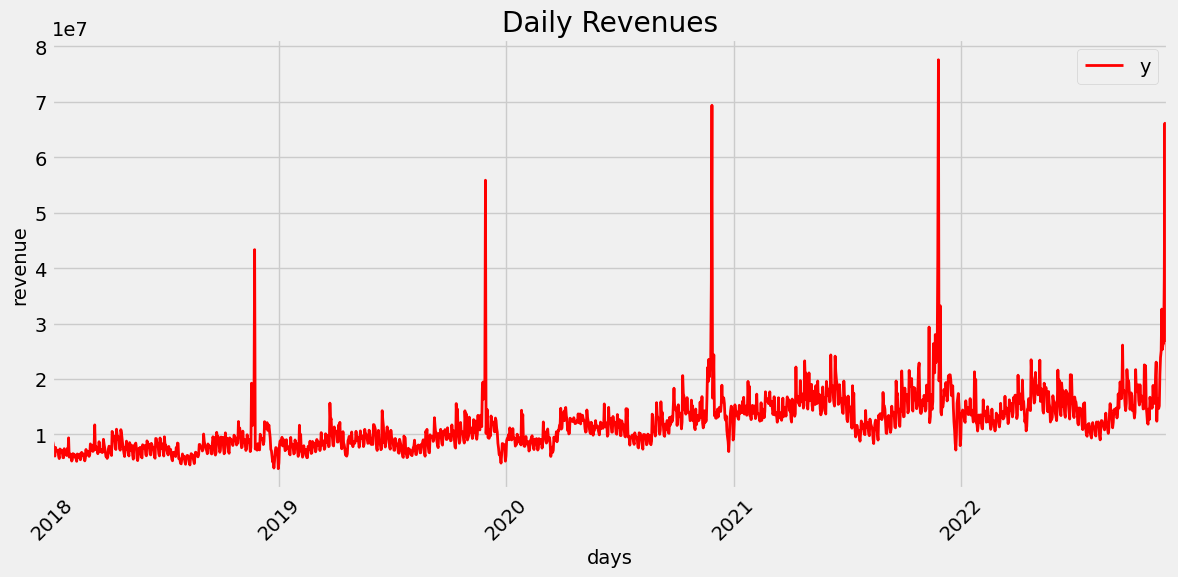

In [133]:
# Let's see some more visualizations for understanding
# Daily closing price plot
df['y'].plot(title='Daily Revenues',figsize=(12, 6), color='red', linewidth=2)
plt.xlabel('days')
plt.ylabel('revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show

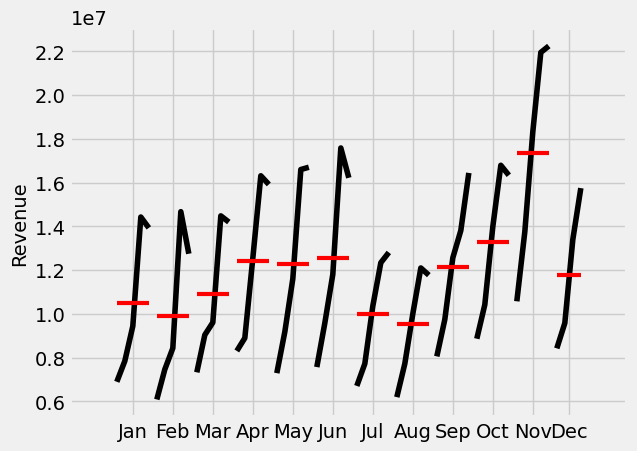

In [134]:
#plotting the monthly seaasonality

month_plot(df['y'].resample('M').mean(), ylabel='Revenue')
plt.show()

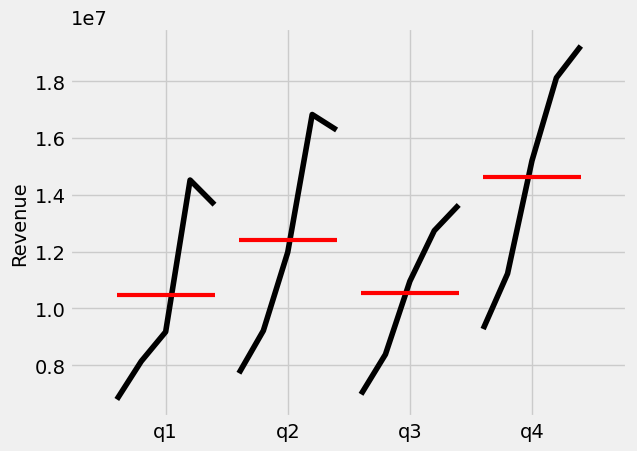

In [135]:
#plotting the monthly seaasonality

quarter_plot(df['y'].resample('Q').mean(), ylabel='Revenue')
plt.show()

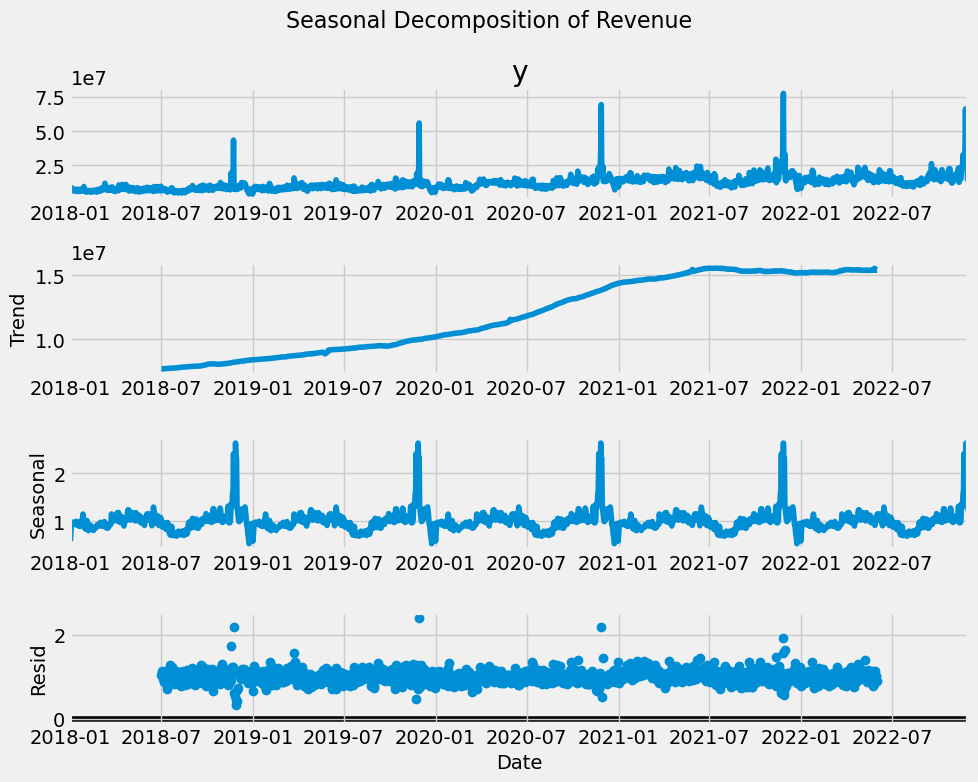

In [136]:
#seasonal decompostion plots for the data
# Seasonality:
# 24 for hourly
# 7 or 365 for daily, but in most cases 7 is preffered
# 52 for weekly
# 4 for quarterly
# 5 for weekdays

decomposition= seasonal_decompose(df['y'], 
                   model= 'mul', 
                   period=365)

fig= decomposition.plot()
fig.set_size_inches(10,8)



fig.axes[-1].set_xlabel('Date')

fig.suptitle('Seasonal Decomposition of Revenue', fontsize=16)

plt.tight_layout()

    



plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

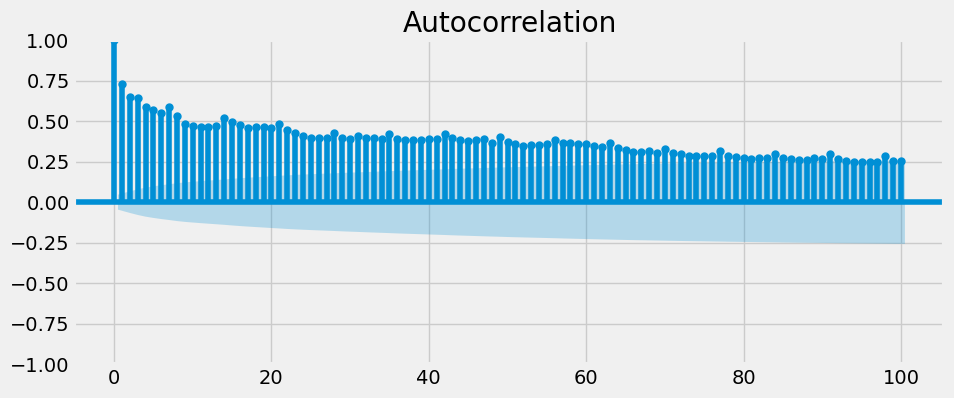

In [137]:

# Plot the autocorrelation (ACF)

fig, ax =plt.subplots(figsize=(10,4))

plot_acf(df['y'], lags=100, ax= ax)

plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

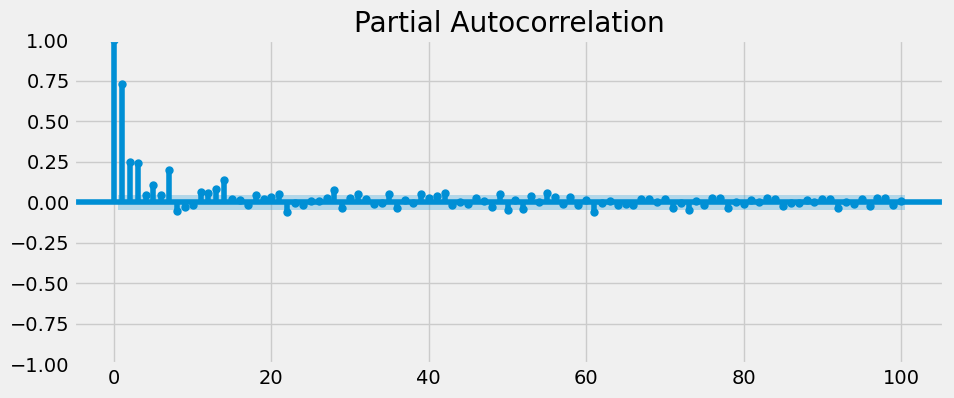

In [138]:
# partial autocorrelation (PACF), for soecific relationship between data points

fig, ax =plt.subplots(figsize=(10,4))

plot_pacf(df['y'], lags=100, ax= ax)

plt.show

# Stationarity

In [139]:
# Perform the ADF Test

result= adfuller(df.y)

print('p-value: %f' % result[1])


if result[1] < 0.05:
    
    print("The time series is stationary")
else:
    print("The time series is not stationary")

p-value: 0.101904
The time series is not stationary


# Differencing

In [140]:
# First difference
df['y_diff'] = df['y'].diff()


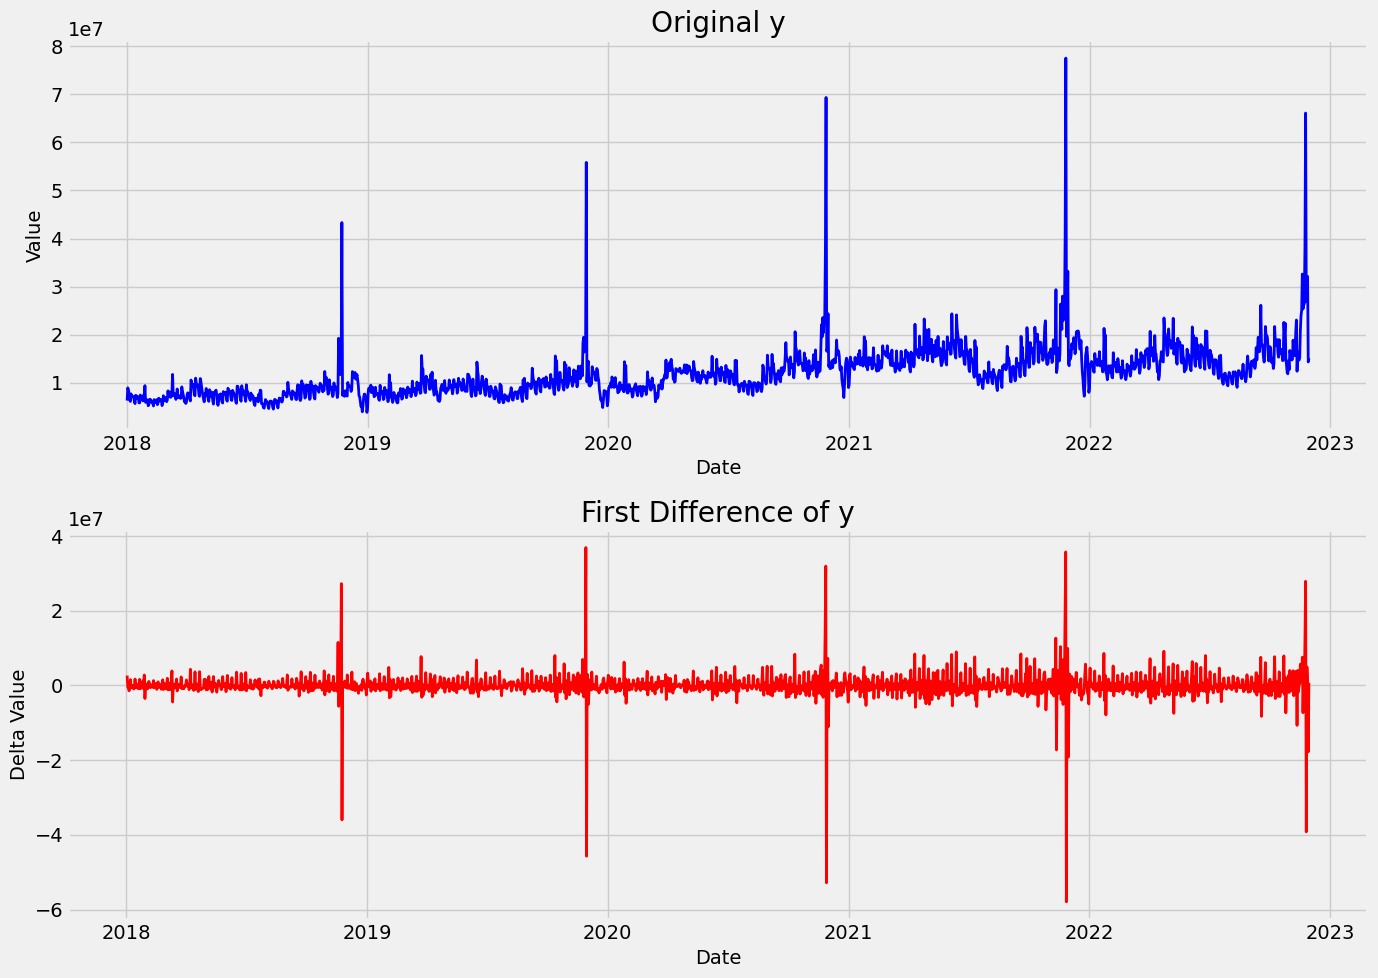

In [145]:

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# First plot: Original y
axes[0].plot(df['y'], color='blue', linewidth=2)
axes[0].set_title('Original y')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].grid(True)

# Second plot: Differenced y
axes[1].plot(df['y_diff'], color='red', linewidth=2)
axes[1].set_title('First Difference of y')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Delta Value')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()



In [146]:
# Perform the ADF Test

result= adfuller(df['y_diff'].dropna())

print('p-value: %f' % result[1])


if result[1] < 0.05:
    
    print("The time series is stationary")
else:
    print("The time series is not stationary")

p-value: 0.000000
The time series is stationary


# ARIMA Model

# Spilliting the data to traing and testing

In [175]:
#training and test split
# Goal: to predict the next quarter (13 weeks)
periods=30
train,test= df.iloc[:-periods], df.iloc[-periods:]


test


,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85,1.50,4014654.0
2022-11-02,15827022.0,20.76,0.94,-876658.0
2022-11-03,16154319.0,21.85,0.92,327297.0
2022-11-04,14707212.0,20.17,0.88,-1447107.0
2022-11-05,14877530.0,17.85,0.41,170318.0
2022-11-06,18835528.0,16.40,0.31,3957998.0
2022-11-07,16094516.0,17.11,0.30,-2741012.0
2022-11-08,15589508.0,16.64,0.29,-505008.0
2022-11-09,16608320.0,18.72,0.74,1018812.0


In [176]:
train.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27,1.09,NaN
2018-01-02,8922076.0,30.87,1.08,2651237.0
2018-01-03,8446101.0,28.11,1.01,-475975.0
2018-01-04,7785798.0,27.32,0.96,-660303.0
2018-01-05,6375303.0,25.70,0.90,-1410495.0


In [177]:
test.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85,1.50,4014654.0
2022-11-02,15827022.0,20.76,0.94,-876658.0
2022-11-03,16154319.0,21.85,0.92,327297.0
2022-11-04,14707212.0,20.17,0.88,-1447107.0
2022-11-05,14877530.0,17.85,0.41,170318.0


In [157]:
# Using pmdarima for arima model and the best perameters

model = auto_arima(train['y'], seasonal= False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Tue, 29 Apr 2025   AIC                          57650.535
Time:                        00:21:17   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.34e+43. Standard errors may be unstable.
"""

In [159]:
# perdictions 
predictions_arima= model.predict(n_periods = len(test))
predictions_arima

2022-11-01    1.445299e+07
2022-11-02    1.474103e+07
2022-11-03    1.503283e+07
2022-11-04    1.527520e+07
2022-11-05    1.534078e+07
2022-11-06    1.553442e+07
2022-11-07    1.554542e+07
2022-11-08    1.563967e+07
2022-11-09    1.565016e+07
2022-11-10    1.569221e+07
2022-11-11    1.570256e+07
2022-11-12    1.571953e+07
2022-11-13    1.572734e+07
2022-11-14    1.573420e+07
2022-11-15    1.573904e+07
2022-11-16    1.574197e+07
2022-11-17    1.574462e+07
2022-11-18    1.574600e+07
2022-11-19    1.574734e+07
2022-11-20    1.574804e+07
2022-11-21    1.574869e+07
2022-11-22    1.574906e+07
2022-11-23    1.574937e+07
2022-11-24    1.574956e+07
2022-11-25    1.574971e+07
2022-11-26    1.574981e+07
2022-11-27    1.574988e+07
2022-11-28    1.574994e+07
2022-11-29    1.574997e+07
2022-11-30    1.575000e+07
Freq: D, dtype: float64

# function to assess model and visualize output

<Figure size 1000x400 with 0 Axes>

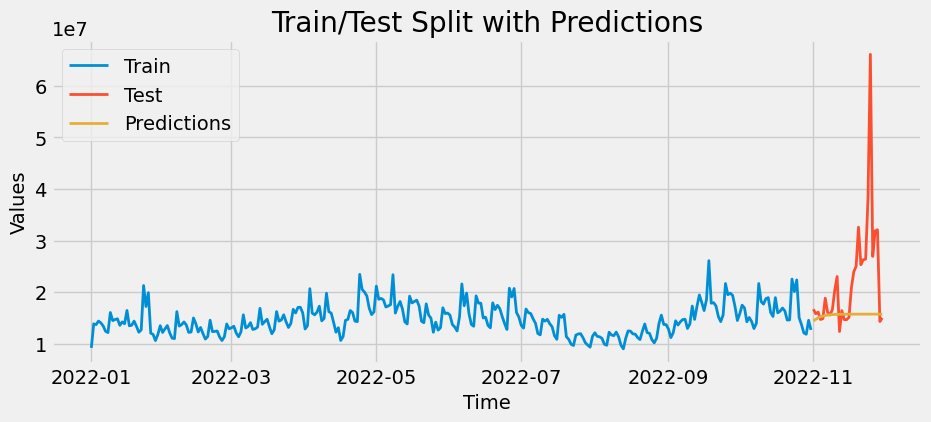

The MAE is 7267306.02
The RMSE is 12366038.30
The MAPE is 24.15%


In [163]:
def model_assessment(train, test, predictions, chart_title):
    plt.figure(figsize=(10, 4))  
    plt.figure(figsize=(10, 4))  

    plt.plot(train, label='Train',linewidth=2)
    plt.plot(test, label='Test',linewidth=2)
    plt.plot(predictions
             , label='Predictions', linewidth=2)

    plt.legend()  
    plt.title('Train/Test Split with Predictions')  
    plt.xlabel('Time')  
    plt.ylabel('Values')  

    plt.show()
    
    mae = mean_absolute_error(test,predictions)
    print(f"The MAE is {mae:.2f}")

    rmse = mean_squared_error(test,predictions, squared= False)
    print(f"The RMSE is {rmse:.2f}")
    
    mape = mean_absolute_percentage_error(test,predictions)
    print(f"The MAPE is {100*mape:.2f}%")
    
model_assessment(train['y']['2022':],test['y'], predictions_arima, "ARIMA")

# SARIMA

In [168]:
model_sarima = auto_arima(train['y'], m=7)

model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Tue, 29 Apr 2025   AIC                          57546.103
Time:                                   01:05:45   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4682.814      2.150      0.032     890.171    1.92e+04
ar.L1         -0.3476      0.072     -4.797      0.000      -0.490      -0.206
ar.L2          0.1857      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8713      0.172      5.071      0.000       0.535       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848646.31
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+31. Standard errors may be unstable.
"""

In [169]:
# perdictions 
predictions_sarima= model_sarima.predict(n_periods = len(test))
predictions_sarima

2022-11-01    1.513412e+07
2022-11-02    1.504533e+07
2022-11-03    1.464458e+07
2022-11-04    1.382189e+07
2022-11-05    1.398003e+07
2022-11-06    1.697852e+07
2022-11-07    1.583305e+07
2022-11-08    1.605208e+07
2022-11-09    1.575796e+07
2022-11-10    1.523584e+07
2022-11-11    1.428028e+07
2022-11-12    1.448987e+07
2022-11-13    1.761289e+07
2022-11-14    1.658422e+07
2022-11-15    1.682758e+07
2022-11-16    1.635486e+07
2022-11-17    1.582120e+07
2022-11-18    1.482106e+07
2022-11-19    1.499264e+07
2022-11-20    1.780765e+07
2022-11-21    1.673569e+07
2022-11-22    1.694578e+07
2022-11-23    1.665823e+07
2022-11-24    1.616894e+07
2022-11-25    1.526419e+07
2022-11-26    1.547008e+07
2022-11-27    1.842687e+07
2022-11-28    1.745383e+07
2022-11-29    1.769223e+07
2022-11-30    1.726671e+07
Freq: D, dtype: float64

<Figure size 1000x400 with 0 Axes>

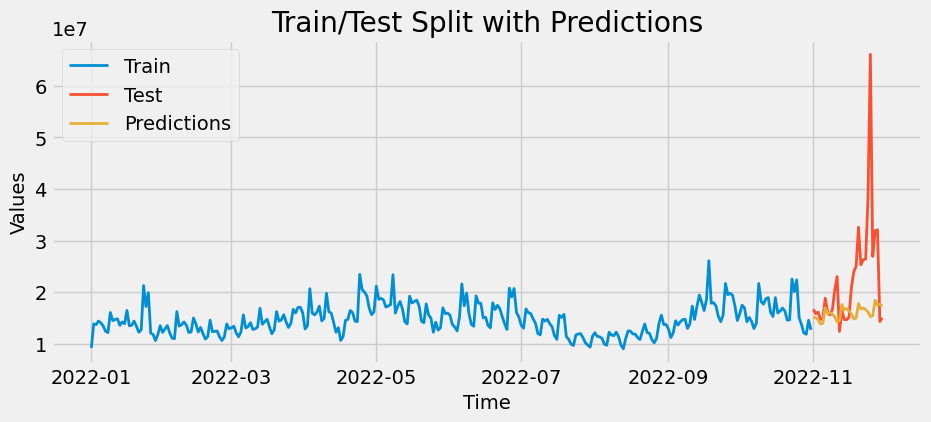

The MAE is 7210547.75
The RMSE is 12152391.52
The MAPE is 24.54%


In [170]:
def model_assessment(train, test, predictions, chart_title):
    plt.figure(figsize=(10, 4))  
    plt.figure(figsize=(10, 4))  

    plt.plot(train, label='Train',linewidth=2)
    plt.plot(test, label='Test',linewidth=2)
    plt.plot(predictions
             , label='Predictions', linewidth=2)

    plt.legend()  
    plt.title('Train/Test Split with Predictions')  
    plt.xlabel('Time')  
    plt.ylabel('Values')  

    plt.show()
    
    mae = mean_absolute_error(test,predictions)
    print(f"The MAE is {mae:.2f}")

    rmse = mean_squared_error(test,predictions, squared= False)
    print(f"The RMSE is {rmse:.2f}")
    
    mape = mean_absolute_percentage_error(test,predictions)
    print(f"The MAPE is {100*mape:.2f}%")
    
model_assessment(train['y']['2022':],test['y'], predictions_sarima, "SARIMA")

# SARIMAX

In [263]:
#transform regressors to floats
df['discount_rate']=df['discount_rate'].str.replace('%','').astype(float)
df['coupon_rate']=df['coupon_rate'].str.replace('%','').astype(float)
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27,1.09
2018-01-02,8922076.0,30.87,1.08
2018-01-03,8446101.0,28.11,1.01
2018-01-04,7785798.0,27.32,0.96
2018-01-05,6375303.0,25.70,0.90


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
dtypes: float64(3)
memory usage: 56.1 KB


In [267]:
#training and test split
# Goal: to predict the next quarter (13 weeks)
periods=30
exog_train,exog_test=  df.iloc[1:3,:-periods], df.iloc[-periods:,1:3]


exog_test


,discount_rate,coupon_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41
2022-11-06,16.40,0.31
2022-11-07,17.11,0.30
2022-11-08,16.64,0.29
2022-11-09,18.72,0.74


In [179]:
model_sarimax = auto_arima(train['y'], 
                           m=7,
                           X= exog_train )

model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Tue, 29 Apr 2025   AIC                          57250.045
Time:                                   01:27:02   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7880.082      2.083      0.037     966.042    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.148      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05    6.1e+04     15.120      0.000    8.03e+05    1.04e+06
ar.L1            -0.6527      0.155     -4.202      0.000      -0.957      -0.348
ar.L2             0.1829      0.048      3.771      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.690      0.490      -0.196       0.410
ma.L2            -0.6925      0.124     -5.573      0.000      -0.936      -0.449
ar.S.L7           0.0523      0.187      0.280      0.779      -0.313       0.418
ar.S.L14          0.8999      0.177      5.082      0.000       0.553       1.247
ma.S.L7           0.0183      0.182      0.101      0.920      -0.338       0.375
ma.S.L14         -0.8501      0.160     -5.308      0.000      -1.164      -0.536
sigma2         7.655e+12      0.016   4.78e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075154.46
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.94e+28. Standard errors may be unstable.
"""

In [180]:
# perdictions 
predictions_sarimax= model_sarimax.predict(n_periods = len(test), X= exog_test)
predictions_sarimax

2022-11-01    1.675240e+07
2022-11-02    1.494581e+07
2022-11-03    1.488475e+07
2022-11-04    1.296486e+07
2022-11-05    1.205535e+07
2022-11-06    1.394964e+07
2022-11-07    1.341730e+07
2022-11-08    1.328254e+07
2022-11-09    1.441188e+07
2022-11-10    2.077612e+07
2022-11-11    2.121905e+07
2022-11-12    1.346377e+07
2022-11-13    1.489112e+07
2022-11-14    1.299935e+07
2022-11-15    1.348094e+07
2022-11-16    1.398051e+07
2022-11-17    1.803928e+07
2022-11-18    1.675166e+07
2022-11-19    1.712368e+07
2022-11-20    1.980751e+07
2022-11-21    1.847883e+07
2022-11-22    1.908211e+07
2022-11-23    1.913617e+07
2022-11-24    2.068917e+07
2022-11-25    1.926331e+07
2022-11-26    1.851309e+07
2022-11-27    2.073207e+07
2022-11-28    2.607969e+07
2022-11-29    1.588264e+07
2022-11-30    1.479932e+07
Freq: D, dtype: float64

<Figure size 1000x400 with 0 Axes>

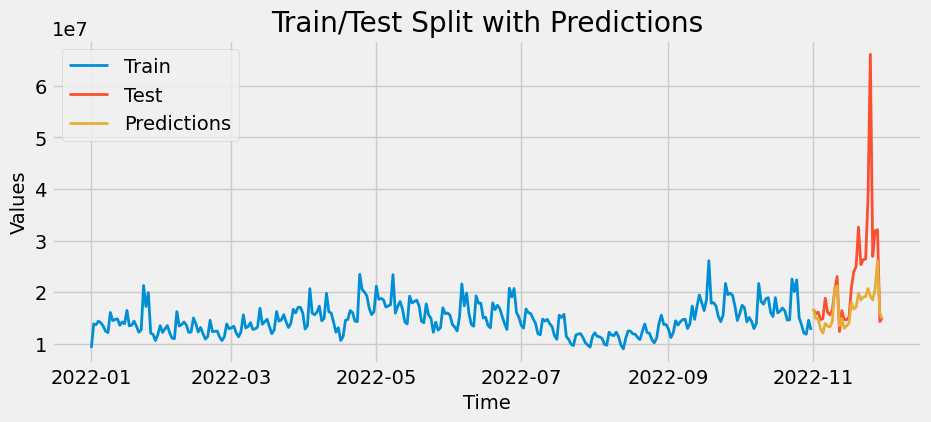

The MAE is 5716444.55
The RMSE is 10394513.44
The MAPE is 19.36%


In [181]:
def model_assessment(train, test, predictions, chart_title):
    plt.figure(figsize=(10, 4))  
    plt.figure(figsize=(10, 4))  

    plt.plot(train, label='Train',linewidth=2)
    plt.plot(test, label='Test',linewidth=2)
    plt.plot(predictions
             , label='Predictions', linewidth=2)

    plt.legend()  
    plt.title('Train/Test Split with Predictions')  
    plt.xlabel('Time')  
    plt.ylabel('Values')  

    plt.show()
    
    mae = mean_absolute_error(test,predictions)
    print(f"The MAE is {mae:.2f}")

    rmse = mean_squared_error(test,predictions, squared= False)
    print(f"The RMSE is {rmse:.2f}")
    
    mape = mean_absolute_percentage_error(test,predictions)
    print(f"The MAPE is {100*mape:.2f}%")
    
model_assessment(train['y']['2022':],test['y'], predictions_sarimax, "SARIMAX")

# Cross-Validation for Time Series

In [195]:
# define the model to do CV

model_cv = ARIMA(order= (2, 1, 2), seasonal_order= (2, 0, 2, 7))

In [196]:
# Set the CV rules

cv= model_selection.RollingForecastCV(h= 30, step = 15, initial = df.shape[0]-180 )

In [197]:
# inputs for CV

cv_score = model_selection.cross_val_score(model_cv,
                                          y =df['y'],
                                          X= df.iloc[:,1:3],
                                          scoring= 'mean_squared_error',
                                          cv=cv,
                                          verbose=1,
                                          error_score= 10000000000000000000)

In [198]:
cv_score

array([1.15279778e+13, 1.38389274e+13, 1.19906753e+13, 1.23862232e+12,
       8.50987028e+11, 7.03694346e+12, 1.22150951e+13, 5.90272898e+12,
       2.97141591e+13, 1.11654543e+13, 1.08045910e+14])

In [199]:
rmse = np.sqrt(np.average(cv_score))
print(f"The RMSE is {int(rmse)}")

The RMSE is 4405858


# Parameter Tuning

In [200]:
# Defining parameter

param_grid = {'p': [1,2,3],
              'd': [0,1],
              'q': [1,2,3],
              'P': [1,2],
              'D': [0],
              'Q': [1,2]
             }
grid = ParameterGrid(param_grid)
len(list(grid))

72

In [202]:
# Parameter Tuning Loop
rmse_list = []
for params in grid:
    # builds the model with a set of parameters
    model_cv = ARIMA(order= (params['p'], params['d'], params['q']), 
                     seasonal_order= (params['P'], params['D'], params['Q'], 7))
# Evaluate  the model
    cv= model_selection.RollingForecastCV(h= 30, step = 15, initial = df.shape[0]-180 )
# score the model

    cv_score = model_selection.cross_val_score(model_cv,
                                          y =df['y'],
                                          X= df.iloc[:,1:3],
                                          scoring= 'mean_squared_error',
                                          cv=cv,
                                          verbose=1,
                                          error_score= 10000000000000000000)
# store the error

    rmse = np.sqrt(np.average(cv_score))
    rmse_list.append(rmse)

In [211]:
# checking the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] =rmse_list
tuning_results

,D,P,Q,d,p,q,rmse
0,0,1,1,0,1,1,4.062626e+06
1,0,1,1,0,1,2,4.045200e+06
2,0,1,1,0,1,3,4.044964e+06
3,0,1,1,0,2,1,4.059187e+06
4,0,1,1,0,2,2,4.057299e+06
...,...,...,...,...,...,...,...
67,0,2,2,1,2,2,4.405859e+06
68,0,2,2,1,2,3,4.366978e+06
69,0,2,2,1,3,1,4.413266e+06
70,0,2,2,1,3,2,4.401648e+06


In [268]:
best_result = tuning_results.loc[tuning_results['rmse'].idxmin()]
best_result

D       0.000000e+00
P       2.000000e+00
Q       1.000000e+00
d       0.000000e+00
p       1.000000e+00
q       2.000000e+00
rmse    4.014443e+06
Name: 37, dtype: float64

In [269]:
#Save the best results
best_params = tuning_results[tuning_results['rmse']==tuning_results['rmse'].min()].transpose()
best_params

,37
D,0.000000e+00
P,2.000000e+00
Q,1.000000e+00
d,0.000000e+00
p,1.000000e+00
q,2.000000e+00
rmse,4.014443e+06


# Predicting the Future


In [270]:
# prepare inputs
y= df['y']
X =df.iloc[:,1:3]

In [271]:
# fetch the best parameters
p= int(best_params.loc['p'])
d= int(best_params.loc['d'])
q= int(best_params.loc['q'])
P= int(best_params.loc['Q'])
D= int(best_params.loc['D'])
Q= int(best_params.loc['Q'])

In [272]:
df_future= pd.read_csv(r"C:\Users\47462\OneDrive\Desktop\Time Series Analysi\future_regressors.csv", index_col="date", parse_dates=True,
               dayfirst= True)
df_future.head()


,revenue,discount_rate,coupon_rate,discount_rate_lag1,coupon_rate_lag1
date,,,,,
2022-12-01,NaN,0.1831,0.0031,0.1710,0.0032
2022-12-02,NaN,0.1995,0.0036,0.1831,0.0031
2022-12-03,NaN,0.2029,0.0032,0.1995,0.0036
2022-12-04,NaN,0.1898,0.0030,0.2029,0.0032
2022-12-05,NaN,0.1810,0.0042,0.1898,0.0030


In [273]:
#prepare the regressors

X_future= df_future.iloc[:,1:3]*100

In [274]:
# Tuned SARIMAX Model
tuned_model = ARIMA(order= (p, d, q), seasonal_order= (P, D, Q, 7))
tuned_model.fit(y, X=X)

ARIMA(order=(1, 0, 2), seasonal_order=(1, 0, 1, 7))

In [278]:
#Forecasting

predictions = tuned_model.predict(n_periods = len(X_future),
                   X= X_future)
predictions

2022-12-01    2.018435e+07
2022-12-02    2.789546e+07
2022-12-03    1.962028e+07
2022-12-04    2.148569e+07
2022-12-05    1.946394e+07
2022-12-06    1.711415e+07
2022-12-07    1.775754e+07
2022-12-08    1.948765e+07
2022-12-09    2.360502e+07
2022-12-10    1.716613e+07
2022-12-11    2.143132e+07
2022-12-12    1.980740e+07
2022-12-13    1.800160e+07
2022-12-14    2.036082e+07
2022-12-15    2.282682e+07
2022-12-16    2.508618e+07
2022-12-17    2.041110e+07
2022-12-18    2.190925e+07
2022-12-19    2.031367e+07
2022-12-20    1.911201e+07
2022-12-21    2.048800e+07
2022-12-22    2.227711e+07
2022-12-23    2.653760e+07
2022-12-24    2.338402e+07
2022-12-25    2.553476e+07
2022-12-26    2.879254e+07
2022-12-27    2.628991e+07
2022-12-28    2.670922e+07
2022-12-29    2.390321e+07
2022-12-30    2.599314e+07
2022-12-31    2.329272e+07
Freq: D, dtype: float64

# Function to plot the future 

In [279]:
def plot_future(y, forecast,title):
    
# plotting training and forecast
    plt.figure(figsize=(10, 4))  

    plt.plot(y, label='Train',linewidth=2)
    plt.plot(forecast, label='Forecast',linewidth=2)


    plt.legend()  
    plt.title(f"Train and Forecast with {title}")  
    plt.xlabel('Time')  
    plt.ylabel('Values')  

    plt.show()

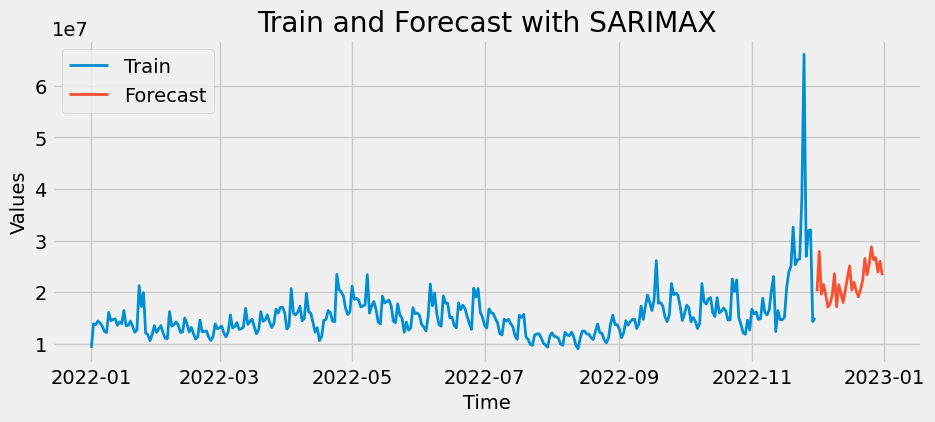

In [281]:
plot_future(y['2022'], predictions,"SARIMAX")